# Optimal Control Notebook

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_bvp
from matplotlib.ticker import LogFormatter


## Question 1

Rearranging (7) to get $ \int_0^T l_1(z(t),v(t)) dt + p_1^T z(T)$

$$\int_0^T \underbrace{D_1 l(x(t)^{[k]},u(t)^{[k]})\cdot z(t) + D_2 l(x(t)^{[k]}, u(t)^{[k]})\cdot v(t) + z(t)^TQ_z z(t) + v(t)^T R_v v(t)}_{\color{red}{l'(z(t),v(t))}} dt + \underbrace{Dm(x(T)^{[k]}\cdot z(T)}_{\color{red}{p_1^T\cdot z(T)}} $$

Factoring:
$$l'(z(t),v(t)) =(a_x(t) + z(t)^TQ_z)z(t) + (b_u(t)+v(t)^TR_v)v(t) $$

Taking a couple directional derivatives gives us

$$ Dl'(z(t),v(t)) = a_x(t) +2Q_zz(t) + b_u(t) +2R_vv(t)$$

Therefore

$$\boxed{a_z(t)  = D_1 l'(z(t),v(t)) = a_x(t) + 2Q_zz(t)  }$$

$$\boxed{b_v(t)  = D_2 l'(z(t),v(t)) = b_u(t) +2R_vv(t)  }$$

Using equation (1), we can factor to isolate for $b_v(t)$ and isolate for $v(t)$ later on.

$$p(t)^TB(t) + b_v(t)^T = 0$$
We find that $b_v(t)^T = -p(t)^TB(t)$, so $b_v(t) = -B(t)^Tp(t)$.
Plugging in what we know about $b_v(t)$, we get

$$b_u(t) + 2R_vv(t) = -B^Tp$$

$$2R_vv(t) = -B^Tp -b_u(t)$$

$$v(t) = -\frac{1}{2}R_v^{-1}B^Tp-\frac{1}{2}R_v^{-1}b_u(t)$$

$$ = -\frac{1}{2}R_v^{-1}(B^Tp+b_u(t))$$

Now we can substitute $v(t)$ and $a_z(t)$ in the $\dot{z}(t)$ and $\dot{p}(t)$ expressions.

$$\dot{z}(t) = A(t)z(t) + B(t)v(t) $$
$$\dot{p}(t) = -A(t)^Tp(t) -a_z(t) $$

$$\dot{z}(t) = Az = B(-\frac{1}{2}R_v^{-1}B^Tp-\frac{1}{2}R_v^{-1}b_u)$$
$$\dot{p}(t) = -A^Tp -2Q_zz-a_x $$

In matrix form, in the form $\dot{\mathbf{x}} = M\mathbf{x} + m$

$$
\boxed{
\begin{bmatrix}
\dot{z}(t)\\
\dot{p}(t)
\end{bmatrix} = \begin{bmatrix}
A & -\frac{1}{2} B R_v^{-1}B^T \\
-2Q_z & -A^T
\end{bmatrix}
\begin{bmatrix}
z(t) \\
p(t)
\end{bmatrix} +
 \begin{bmatrix}
-\frac{1}{2}BR_v^{-1}b_u \\
-a_x
\end{bmatrix}}
$$




## Question #2 Armijo Line Search 2-D Optimization

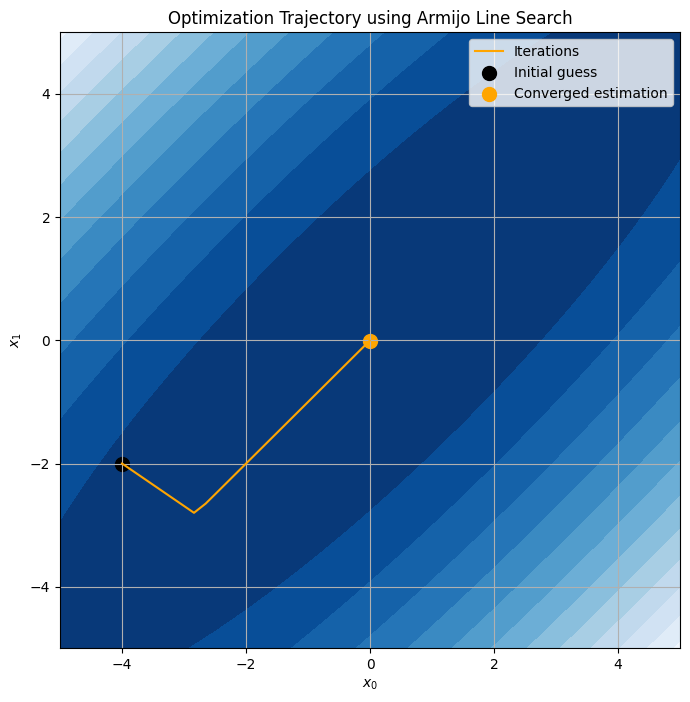

In [ ]:
# Objective function and its gradient
def f(x):
    return 0.26 * (x[0] ** 2 + x[1] ** 2) - 0.46 * x[0] * x[1]

def grad_f(x):
    return np.array([0.52 * x[0] - 0.46 * x[1], 0.52 * x[1] - 0.46 * x[0]])


# Gradient descent with Armijo line search

def armijo_line_search(x, gamma_0, alpha, beta, iters=100):
  # taken from hw4 sheet
    gamma = gamma_0
    trajectory = [x.copy()]
    for ii in range(iters):
        z_k = -grad_f(x)
        while f(x + gamma * z_k) > f(x) + alpha*gamma * np.dot(grad_f(x), z_k):
            gamma = beta*gamma
            print(f"gamma = {gamma}@ time step {ii}")
        x = x + gamma * z_k
        trajectory.append(x.copy())
    return np.array(trajectory)

# Initial guess
x_init = np.array([-4, -2])

# Armijo line search parameters as specified in doc
gamma_0 = 1
alpha = 1e-4
beta = 0.5
iters = 100

# run func
trajectory = armijo_line_search(x_init, gamma_0, alpha, beta, iters =100)

# Plotting
x0_range = np.linspace(-5, 5, 500)
x1_range = np.linspace(-5, 5, 500)
X0, X1 = np.meshgrid(x0_range, x1_range)
Z = f([X0, X1])


plt.figure(figsize=(8, 8))
plt.contourf(X0, X1, f([X0,X1]), levels=15, cmap='Blues_r')

# plt.contourf(X0, X1, Z, levels=np.logspace(-5, 2, 40), cmap="Blues")
plt.plot(trajectory[:, 0], trajectory[:, 1], 'orange', label="Iterations")
plt.scatter(x_init[0], x_init[1], c='black', label="Initial guess", s=100)
plt.scatter(trajectory[-1, 0], trajectory[-1, 1], c='orange', label="Converged estimation", s=100)
plt.xlabel("$x_0$")
plt.ylabel("$x_1$")
# cbar = plt.colorbar(contour_plot, format=LogFormatter())
# cbar.set_label('Contour Levels (log scale)')
plt.legend()
plt.title("Optimization Trajectory using Armijo Line Search")
plt.grid(True)
plt.show()


## Question 3 iLQR

We will test this for three different initial trajectories. Specifically three different control inputs.



In [1]:
import numpy as np
from numpy.linalg import inv

from numpy import cos, sin

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_bvp
from numpy import cos, sin
from numpy.linalg import inv
### define parameters

dt = 0.1
alpha = 1e-4
beta = 0.5
x0 = np.array([0.0, 0.0, np.pi/2.0])
tsteps = 63
# init_u_traj = np.tile(np.array([1.0, -0.5]), reps=(tsteps,1))

init_u_traj = np.tile(np.array([0.5, -0.5]), (tsteps, 1))
R_u = np.diag([40, 20.0])  # Increased control effort cost
# init_u_traj = np.tile(np.array([1.5, -0.2]), (tsteps, 1))
# Q_x = np.diag([15.0, 15.0, 3.0])  # Increased state deviation cost

# Q_x = np.diag([10.0, 10.0, 2.0])
# R_u = np.diag([4.0, 2.0])
P1 = np.diag([20.0, 20.0, 5.0])

Q_z = np.diag([5.0, 5.0, 1.0])
R_v = np.diag([2.0, 1.0])

def dyn(xt, ut):
    theta = xt[2]
    xdot = np.array([cos(theta)*ut[0], sin(theta)*ut[0], ut[1]])
    return xdot

def get_A(t, xt, ut):
    # Compute A (Jacobian of the dynamics with respect to states)
    theta = xt[2]
    return np.array([[0, 0, -sin(theta)*ut[0]],
                     [0, 0, cos(theta)*ut[0]],
                     [0, 0, 0]])

def get_B(t, xt, ut):
    # Compute B (Jacobian of the dynamics with respect to controls)
    theta = xt[2]
    return np.array([[np.cos(theta), 0],
                     [np.sin(theta), 0],
                     [0, 1]])

# Step forward
def step(xt, ut):
    return xt + dt*dyn(xt, ut)

# Trajectory simulation
def traj_sim(x0, ulist):
    tsteps = ulist.shape[0]
    x_traj = np.zeros((tsteps, 3))
    xt = x0.copy()
    for t in range(tsteps):
        xt_new = step(xt, ulist[t])
        x_traj[t] = xt_new.copy()
        xt = xt_new.copy()
    return x_traj


def loss(t, xt, ut):
    xd = np.array([
        2.0 * t / np.pi, 0.0, np.pi / 2.0
    ])  # desired system state at time t

    # State error
    x_error = xt - xd
    x_loss = x_error.T@ (Q_x)@ x_error

    # Control effort
    u_loss = ut.T@(R_u)@ut

    return x_loss + u_loss


def dldx(t, xt, ut):
    xd = np.array([
        2.0*t/np.pi, 0.0, np.pi/2.0
    ])
    # Gradient w.r.t. state
    x_error = xt-xd
    # just the derivatvie of l
    dvec = 2 * (Q_x)@x_error
    return dvec

def dldu(t, xt, ut):
    # Gradient w.r.t. control
    dvec = 2 * (R_u)@ut
    return dvec

#changed this funciton up so we return the objective function so we can use it for grad. descent(armijo line search)
def ilqr_iter(x0, u_traj):
    """
    :param x0: initial state of the system
    :param u_traj: current estimation of the optimal control trajectory
    :return: the descent direction for the control
    """
    DJ_vt = 0
    # forward simulate the state trajectory
    x_traj = traj_sim(x0, u_traj)

    # compute other variables needed for specifying the dynamics of z(t) and p(t)
    A_list = np.zeros((tsteps, 3, 3))
    B_list = np.zeros((tsteps, 3, 2))
    a_list = np.zeros((tsteps, 3))
    b_list = np.zeros((tsteps, 2))
    for t_idx in range(tsteps):
        t = t_idx * dt
        A_list[t_idx] = get_A(t, x_traj[t_idx], u_traj[t_idx])
        B_list[t_idx] = get_B(t, x_traj[t_idx], u_traj[t_idx])
        a_list[t_idx] = dldx(t, x_traj[t_idx], u_traj[t_idx])
        b_list[t_idx] = dldu(t, x_traj[t_idx], u_traj[t_idx])

    xd_T = np.array([
        2.0*(tsteps-1)*dt / np.pi, 0.0, np.pi/2.0
    ])  # desired terminal state
    # the derivative
    p1 = P1 @ (x_traj[-1] - xd_T)# replace it to be the terminal condition p(T)

    def zp_dyn(t, zp):
        t_idx = int(t / dt)
        At = A_list[t_idx]
        Bt = B_list[t_idx]
        Qz = Q_z  # Should be defined globally or passed as a parameter
        Rv_inv = np.linalg.inv(R_v)  # R_v should be defined globally or passed as a parameter
        at = a_list[t_idx]
        bt = b_list[t_idx]

        # Substituting the values in the matrix M
        M_11 = At
        M_12 = -(1/2) * Bt @ Rv_inv @ Bt.T
        M_21 = -2 * Qz
        M_22 = -At.T

        # Form the block matrix M
        dyn_mat = np.block([
            [M_11, M_12],
            [M_21, M_22]
        ])

        # Calculate vector m components
        m_1 = -(1/2) * Bt @ Rv_inv @ bt
        m_2 = -at  # Assuming at corresponds to a_x in the equation

        # Form the full vector m
        dyn_vec = np.hstack([m_1, m_2])

        # Calculate the dynamics (M * zp + m)
        return dyn_mat @ zp + dyn_vec

    # this will be the actual dynamics function you provide to solve_bvp,
    # it takes in a list of time steps and corresponding [z(t), p(t)]
    # and returns a list of [zdot(t), pdot(t)]
    def zp_dyn_list(t_list, zp_list):
        list_len = len(t_list)
        zp_dot_list = np.zeros((6, list_len))
        for _i in range(list_len):
            zp_dot_list[:,_i] = zp_dyn(t_list[_i], zp_list[:,_i])
        return zp_dot_list

    # boundary condition (inputs are [z(0),p(0)] and [z(T),p(T)])
    def zp_bc(zp_0, zp_T):
      z_0, p_0 = zp_0[:3], zp_0[3:]
      z_T, p_T = zp_T[:3], zp_T[3:]

      # Assuming p1 should be a vector of zeros if not specified
      p1 = np.zeros(3)  # Define it according to your terminal condition requirements

      # Boundary conditions for the BVP: z(0) = 0 and p(T) = p1
      bc = np.hstack([z_0, p_T - p1])
      return bc

    ### The solver will say it does not converge, but the returned result
    ### is numerically accurate enough for our use
    # zp_traj = np.zeros((tsteps,6))  # replace this by using solve_bvp
    tlist = np.arange(tsteps) * dt
    res = solve_bvp(
        zp_dyn_list, zp_bc, tlist, np.zeros((6,tsteps)),
        max_nodes=100
    )
    zp_traj = res.sol(tlist).T

    z_traj = zp_traj[:,:3]
    p_traj = zp_traj[:,3:]

    v_traj = np.zeros((tsteps, 2))
    for _i in range(tsteps):
        At = A_list[_i]
        Bt = B_list[_i]
        at = a_list[_i]
        bt = b_list[_i]

        zt = z_traj[_i]
        pt = p_traj[_i]
        vt = -(1/2)*inv(R_v)@(Bt.T@pt + bt)
        DJ_vt += at.T @ zt + bt.T @ vt

        v_traj[_i] = vt
    DJ_vt += p1.T @ z_traj[-1]
    return v_traj, DJ_vt

# Start iLQR iterations here
def compute_cost(x_traj, u_traj):
    total_cost = 0
    for i in range(len(u_traj)):
        total_cost += loss(i * dt, x_traj[i], u_traj[i])
    return total_cost

u_traj = init_u_traj.copy()
current_cost = compute_cost(traj_sim(x0, u_traj), u_traj)
#init everythign
objective_values = []
state_trajectories = []
control_trajectories = []

for iter in range(10):
    x_traj = traj_sim(x0, u_traj)
    v_traj, DJ_vt = ilqr_iter(x0, u_traj)

    # Start initial step size gamma
    gamma = 1.0
    improvement = False
    for _ in range(20):  # Limit the number of line search iterations
        new_u_traj = u_traj + gamma * v_traj
        new_x_traj = traj_sim(x0, new_u_traj)
        new_cost = compute_cost(new_x_traj, new_u_traj)
        state_trajectories.append(x_traj.copy())
        control_trajectories.append(u_traj.copy())

        # Compute current cost and store it
        current_cost = compute_cost(x_traj, u_traj)
        objective_values.append(current_cost)


        # Check the Armijo condition
        if new_cost < current_cost + alpha * gamma * DJ_vt:
            u_traj = new_u_traj
            current_cost = new_cost
            improvement = True
            break
        gamma *= beta  # Reduce gamma if condition is not met

    if not improvement:
        print("Converged; No further improvement.")
        break


Converged; No further improvement.


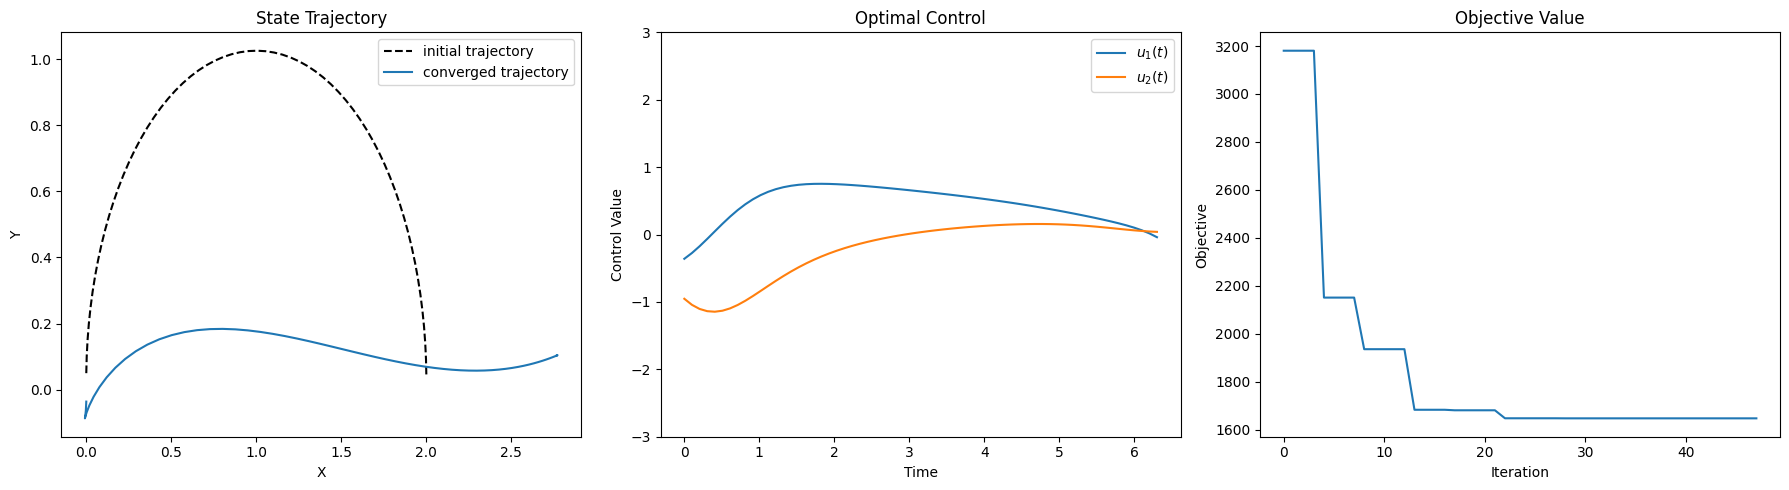

In [15]:
plt.figure(figsize=(18, 5))

# State Trajectory Plot
plt.subplot(1, 3, 1)
init_iter_state = state_trajectories[0]
plt.plot(init_iter_state[:, 0], init_iter_state[:, 1],'--',label = 'initial trajectory', color = "black")

final_iter_state = state_trajectories[-1]
plt.plot(final_iter_state[:, 0], final_iter_state[:, 1],label = 'converged trajectory')
plt.title("State Trajectory")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()

# Control Trajectory Plot
plt.subplot(1, 3, 2)
time = np.linspace(0, dt * tsteps, tsteps)
final_iter_control = control_trajectories[-1]
plt.plot(time, final_iter_control[:, 0], label=f'$u_1(t)$')
plt.plot(time, final_iter_control[:, 1], label=f'$u_2(t)$')
plt.title("Optimal Control")
plt.ylim([-3, 3])
plt.xlabel("Time")
plt.ylabel("Control Value")
plt.legend()

# Objective Value Plot
plt.subplot(1, 3, 3)
plt.plot(objective_values)
plt.title("Objective Value")
plt.xlabel("Iteration")
plt.ylabel("Objective")
# plt.grid(True)

plt.tight_layout()
plt.show()